In [18]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os
from pathlib import Path

# load data 

In [19]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
    vertical_flip=True
)

train_dir = "./images/downloads"
IMG_HEIGHT, IMG_WIDTH = 224, 224
batch_size = 32

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

print(train_data_gen.class_indices)

Found 343 images belonging to 5 classes.
{'Beer': 0, 'Cocktail': 1, 'Lemonade': 2, 'Water': 3, 'Wine': 4}


# display images

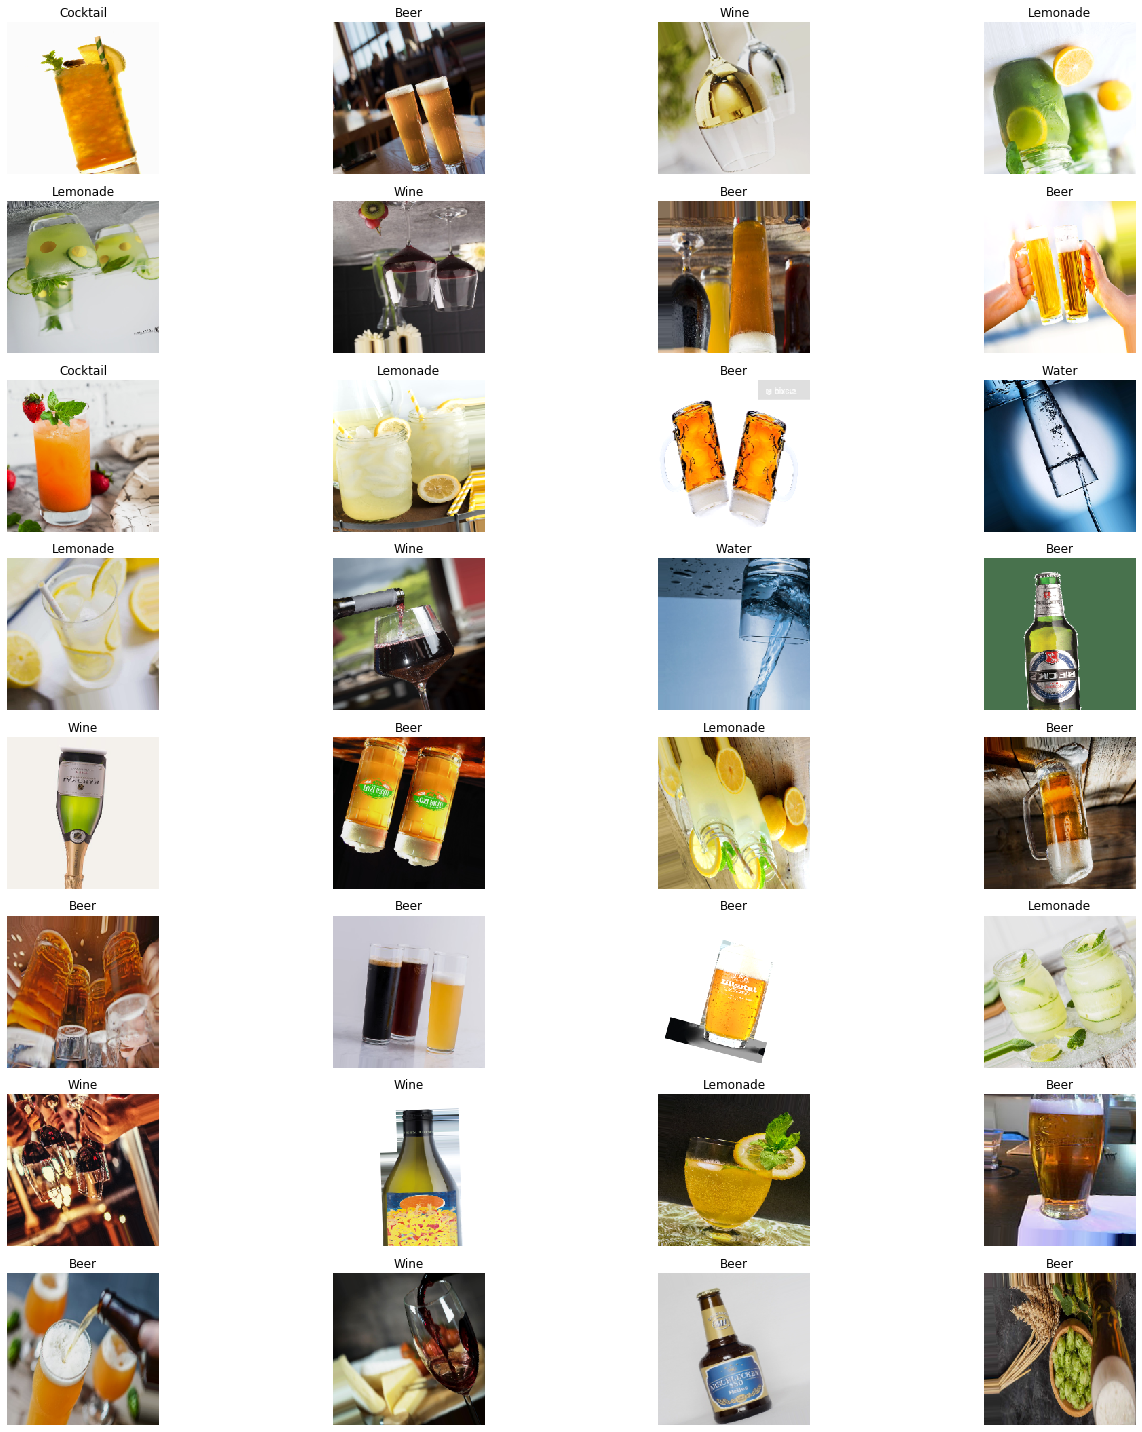

In [20]:
sample_training_images, labels = next(train_data_gen)
class_label = {v:k for k,v in train_data_gen.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

# model

In [21]:
base_model = tf.keras.applications.resnet_v2.ResNet50V2(
        include_top=False,
        pooling='max',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        weights='imagenet')

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(512, 'relu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(train_data_gen.num_classes, 'softmax')
])
    
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 1285      
Total params: 24,746,501
Trainable params: 24,701,061
Non-trainable params: 45,440
_________________________________________________________________


### utility function that will skip batches if there is a broken image in it

In [10]:
def skip_broken_images(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except GeneratorExit:
            break
        except:
            pass

# train fully connected layers

Epoch 1/2
2/2 [==============================] - 139s 70s/step - loss: 8.1875 - categorical_accuracy: 0.2656
Epoch 2/2
2/2 [==============================] - 148s 74s/step - loss: 10.0685 - categorical_accuracy: 0.2344


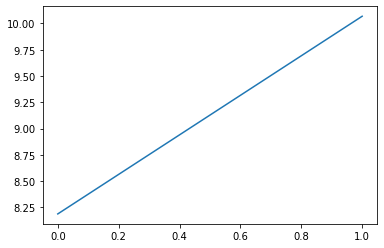

In [22]:
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

history = model.fit_generator(
    skip_broken_images(train_data_gen),
    steps_per_epoch=2, #use way more steps here: number of samples / batch size
    epochs=2, #use way more or use EarlyStopping callback
    callbacks=[]
)
plt.plot(history.history['loss'])

# train complete network

In [ ]:
for layer in base_model.layers:
    layer.trainable = True
    
    
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])    

history = model.fit_generator(
    skip_broken_images(train_data_gen),
    steps_per_epoch=2, #use way more steps here: number of samples / batch size
    epochs=3, #use way more or use EarlyStopping callback
    callbacks=[]
)
plt.plot(history.history['loss'])

Epoch 1/3


# save model

model.save('drink-detection.h5')